In [2]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import data_manager as dm
from PIL import Image
from skimage import filters

In [28]:
%matplotlib inline
from matplotlib.ticker import FormatStrFormatter
from tqdm import tqdm
from skimage.segmentation import watershed, random_walker
from skimage.morphology import disk, ball
FIG_SIZE = (7, 7)

In [4]:
data_folderes = ['/nfs/synology-tomodata/external_data/tomo/Diamond/I13/2020_02/recon/123495/full_recon/20200206141126_123495/TiffSaver-tomo/tomo_123495_02026.tiff',
                 '/nfs/synology-tomodata/external_data/tomo/Diamond/I13/2020_02/recon/123495/full_recon/20200206141126_123495/TiffSaver-tomo/tomo_123495_01960.tiff',
                 '/nfs/synology-tomodata/external_data/tomo/Diamond/I13/2020_02/recon/123495/full_recon/20200206141126_123495/TiffSaver-tomo/tomo_123495_00949.tiff',
                 '/nfs/synology-tomodata/external_data/tomo/Diamond/I13/2020_02/recon/123495/full_recon/20200206141126_123495/TiffSaver-tomo/tomo_123495_00355.tiff']

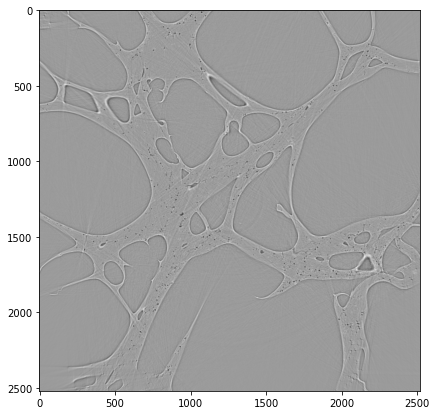

In [5]:

df_number = 1
df = Path(data_folderes[df_number])
img = np.array(Image.open(df))
fig, ax = plt.subplots(figsize=FIG_SIZE)

ax.imshow(img, cmap='gray')

In [6]:
None==True

False

In [14]:
def plot_hist(img, ax, x_min=None, x_max=None):
    gray_volume = np.copy(img)
    if x_min:
        gray_volume_min = x_min
    else:
        gray_volume_min = np.min(gray_volume)

    if x_max:
        gray_volume_x_max = x_max
    else:
        gray_volume_max = np.max(gray_volume)

    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.hist(gray_volume.ravel(),
            bins=np.linspace(gray_volume_min, gray_volume_max, 255))
    ax.grid()

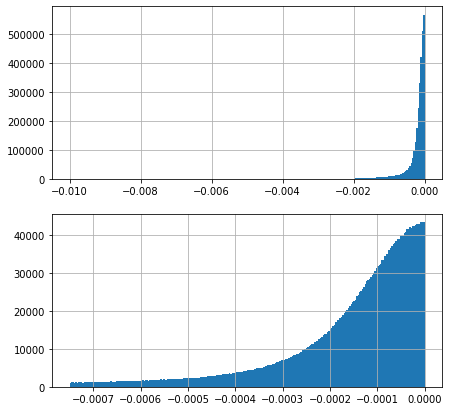

In [8]:
fig, ax = plt.subplots(2, 1, figsize=FIG_SIZE)
plot_hist(img, ax[0])
plot_hist(img, ax[1], x_min=-0.00075)

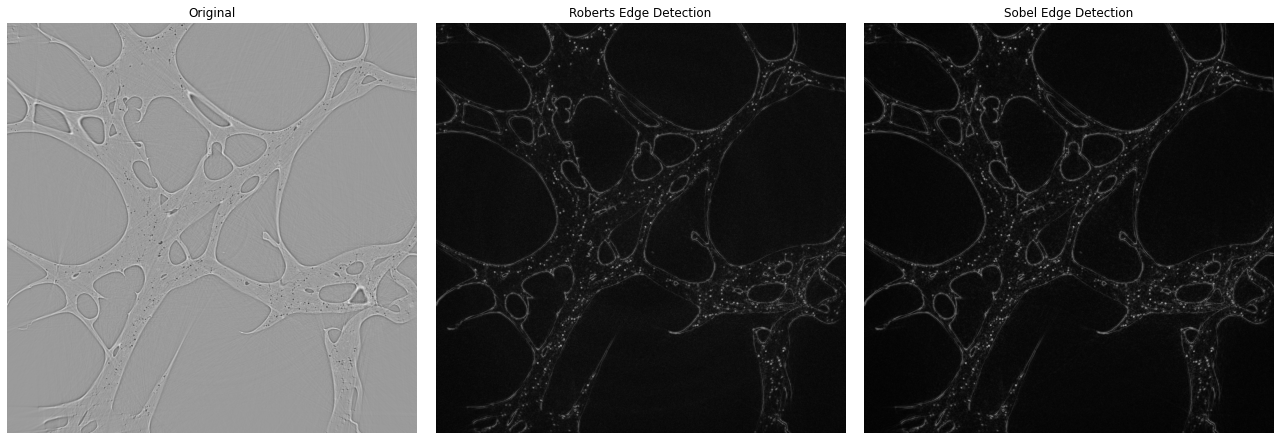

In [16]:

edge_roberts = filters.roberts(img)
edge_sobel = filters.sobel(img)

fig, axes = plt.subplots(ncols=3, sharex=True, sharey=True,
                         figsize=(18, 6))

axes[0].imshow(img, cmap=plt.cm.gray)
axes[0].set_title('Original')

axes[1].imshow(edge_roberts, cmap=plt.cm.gray)
axes[1].set_title('Roberts Edge Detection')

axes[2].imshow(edge_sobel, cmap=plt.cm.gray)
axes[2].set_title('Sobel Edge Detection')

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

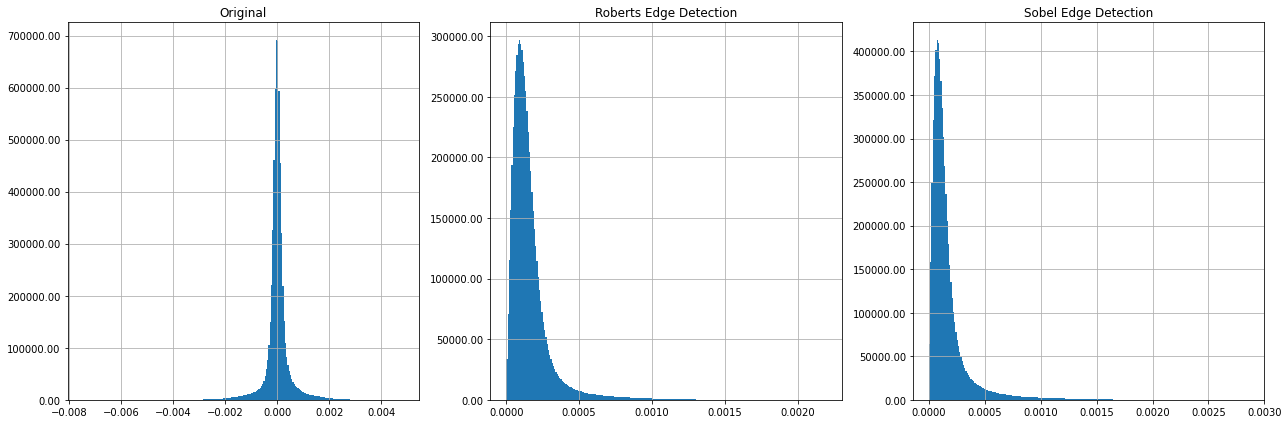

In [17]:
fig, axes = plt.subplots(ncols=3, figsize=(18, 6))

plot_hist(img, axes[0])
axes[0].set_title('Original')

plot_hist(edge_roberts, axes[1])
axes[1].set_title('Roberts Edge Detection')

plot_hist(edge_sobel, axes[2])
axes[2].set_title('Sobel Edge Detection')

plt.tight_layout()
plt.show()

In [24]:
def create_mask(img):
    thrs1 = np.percentile(img.flat[::100], 90)
    # беру выборку из каждого 100-ого индекса массиво и ищу число, ниже которого 80% чисел выборки 
    thrs2 = np.percentile(img.flat[::100], 10)
    # беру выборку из каждого 100-ого индекса массиво и ищу число, ниже которого 10% чисел выборки
    
    need_squeeze = False
    if img.ndim == 2:
        need_squeeze = True
        img = img[np.newaxis,:,:]
        # добавили еще 1 измерение к 2мерному изображению(если оно было)
    
    # markers = np.zeros_like(img, dtype=np.uint16)
    # markers[img > thrs1] = 1
    # markers[img < thrs2] = 2
    # t = random_walker(img.astype(np.float32), markers, 1)
    tt = np.zeros((3,img.shape[0],img.shape[1], img.shape[2]), dtype=np.uint16)
    for j in range(3):
        t = np.zeros_like(img, dtype=np.uint16)
        for i in tqdm(range(t.shape[j])):
            t_img = img.take(i,j)
            # для каждой оси 3д массива выбирается плоскость (перпендикулярный к направлению оси)
            markers = np.zeros_like(t_img, dtype=np.uint16)
            markers[t_img > thrs1] = 1
            markers[t_img < thrs2] = 2
            # для этой плоскости создается маска, с элементами, которые превышают (вниз или вверх) пороговые значения 
            # (верочтно, пора или материал)
            rt = random_walker(t_img, markers, beta=1)
            # запускаяем random_walker с позиций маркеров и сегментируем
            if j==0:
                t[i] = rt
            elif j==1:
                t[:,i,:] = rt
            elif j==2:
                t[:,:,i] = rt
            # вставили плоскость назад в изображение(в этом цикле все по одной оси для каждой ее насечки)
        if need_squeeze:
            t = np.squeeze(t)
            # убираем 1-мерные размерности в массивах
            
        tt[j]=t
        #собираем все плоскости сегментации в одну кучу. Получаем 4д массив
    return tt      

In [25]:
mask_vanila = create_mask(edge_sobel)-1
mask_mean = np.median(mask_vanila, axis=0)

100%|██████████| 2520/2520 [00:09<00:00, 270.19it/s]


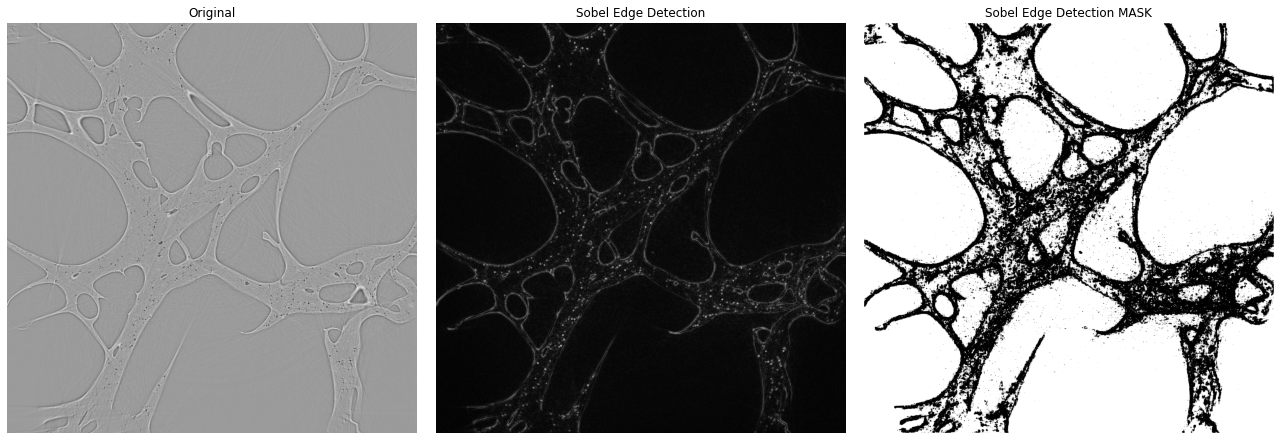

In [27]:
fig, axes = plt.subplots(ncols=3, sharex=True, sharey=True,
                         figsize=(18, 6))

axes[0].imshow(img, cmap=plt.cm.gray)
axes[0].set_title('Original')

axes[1].imshow(edge_sobel, cmap=plt.cm.gray)
axes[1].set_title('Sobel Edge Detection')

axes[2].imshow(mask_mean[0], cmap=plt.cm.gray)
axes[2].set_title('Sobel Edge Detection MASK')

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
mask_no_stones = binary_closing(mask_mean, ball(1), border_value=1)
fig, axes = plt.subplots(figsize=(6, 6))

axes[0].imshow(img, cmap=plt.cm.gray)
axes[0].set_title('Original')

axes[2].imshow(mask_mean[0], cmap=plt.cm.gray)
axes[2].set_title('Sobel Edge Detection MASK')